In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

# Load data
df = pd.read_csv("credit_risk_dataset.csv")

# Check for missing values
print("Missing Values:\n", df.isnull().sum())

# Handle missing values
imputer_num = IterativeImputer(max_iter=10, random_state=42)  # For numerical features
imputer_cat = SimpleImputer(strategy='most_frequent')  # For categorical features

# Impute numerical columns
num_cols = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 
            'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
df[num_cols] = imputer_num.fit_transform(df[num_cols])

# Impute categorical columns
cat_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])

Missing Values:
 person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64


In [14]:
# Fix person_emp_length outliers (e.g., 123 years → cap at 40)
df['person_emp_length'] = df['person_emp_length'].clip(upper=40)

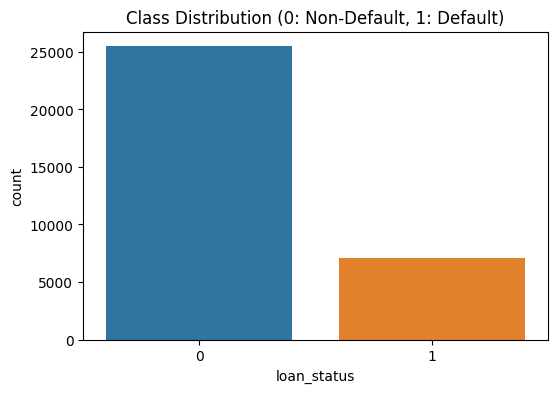

In [15]:
plt.figure(figsize=(6, 4))
sns.countplot(x='loan_status', data=df)
plt.title("Class Distribution (0: Non-Default, 1: Default)")
plt.savefig('class_distribution.png', dpi=300)
plt.show()

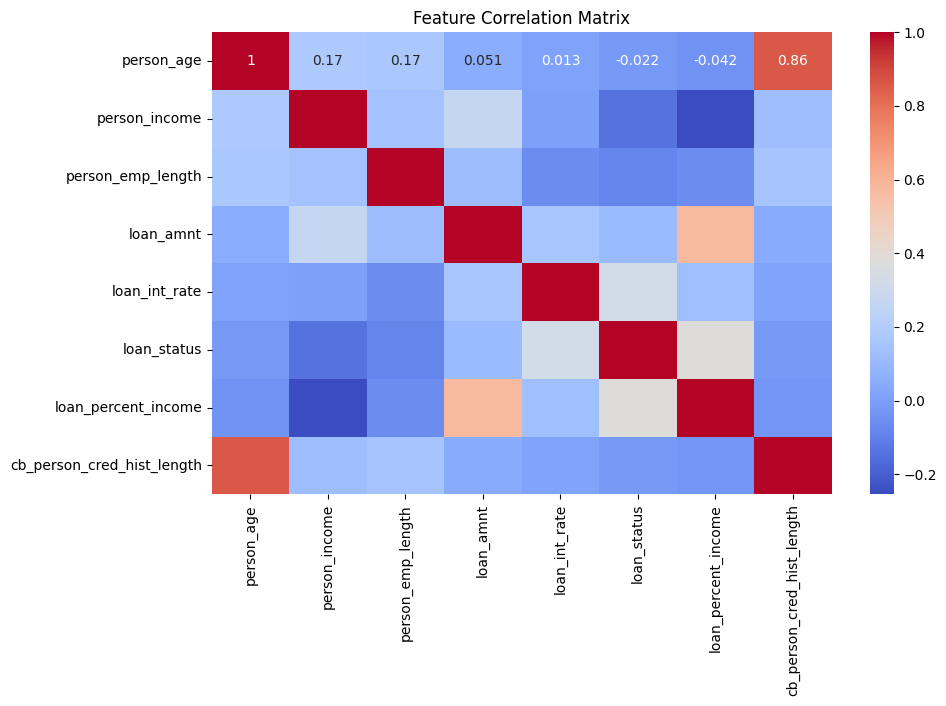

In [16]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.savefig('correlation_heatmap.png', dpi=300)
plt.show()

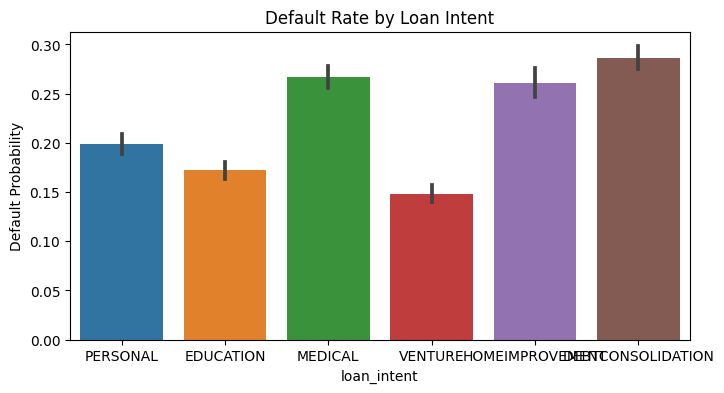

In [17]:
plt.figure(figsize=(8, 4))
sns.barplot(x='loan_intent', y='loan_status', data=df, estimator=np.mean)
plt.title("Default Rate by Loan Intent")
plt.ylabel("Default Probability")
plt.savefig('loan_intent_vs_default.png', dpi=300)
plt.show()

In [18]:
# Bin age into groups
df['age_group'] = pd.cut(df['person_age'], bins=[18, 25, 35, 50, 100], labels=['18-25', '26-35', '36-50', '50+'])

# Create debt-to-income ratio
df['debt_to_income'] = df['loan_amnt'] / df['person_income']

In [19]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# One-hot encode categorical features
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_cats = encoder.fit_transform(df[cat_cols])
encoded_cats_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(cat_cols))

# Label encode target
df = pd.concat([df.drop(cat_cols, axis=1), encoded_cats_df], axis=1)

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression

# Load data
df = pd.read_csv("credit_risk_dataset.csv")

# Handle missing values and anomalies
df['person_emp_length'] = df['person_emp_length'].clip(upper=40)
df.fillna({'person_emp_length': df['person_emp_length'].median()}, inplace=True)

# Define features and target
X = df.drop("loan_status", axis=1)
y = df["loan_status"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Preprocessing
num_cols = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 
           'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
cat_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),  # Handle NaN
            ('scaler', StandardScaler())
        ]), num_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle NaN
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), cat_cols)
    ]
)

# Full pipeline with imblearn
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression())
])

# Hyperparameter tuning
param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)  # Now this will work

# Access best estimator
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Estimator: {grid_search.best_estimator_}")

Best Parameters: {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'loan_percent_income',
                                                   'cb_person_cred_hist_length']),
    

c:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


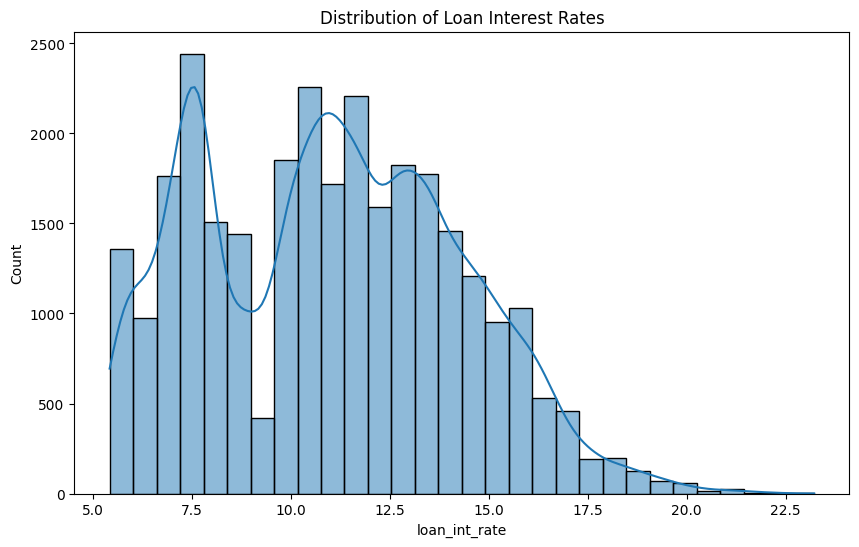

In [28]:
plt.figure(figsize=(10, 6))
sns.histplot(df['loan_int_rate'], kde=True, bins=30)
plt.title("Distribution of Loan Interest Rates")
plt.savefig('loan_int_rate_dist.png', dpi=300)
plt.show()

<Figure size 800x600 with 0 Axes>

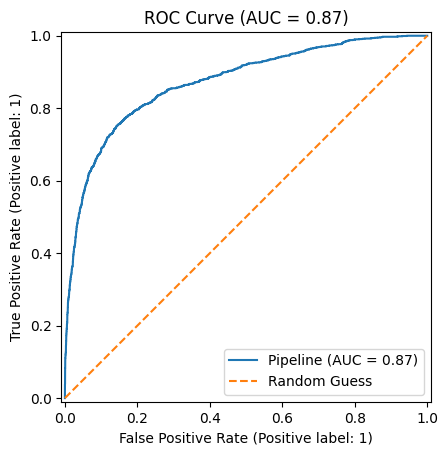

In [29]:
from sklearn.metrics import RocCurveDisplay

plt.figure(figsize=(8, 6))
RocCurveDisplay.from_estimator(grid_search.best_estimator_, X_test, y_test)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
plt.title("ROC Curve (AUC = {:.2f})".format(grid_search.best_score_))
plt.legend()
plt.savefig('roc_curve.png', dpi=300)
plt.show()

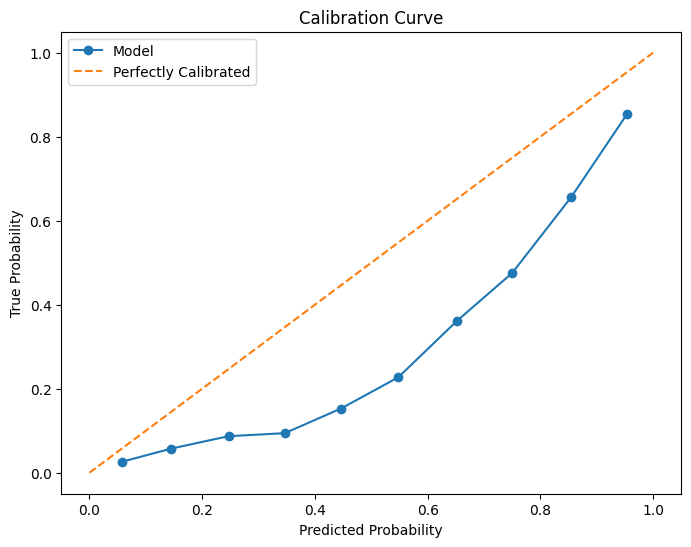

In [30]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, grid_search.predict_proba(X_test)[:, 1], n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel("Predicted Probability")from sklearn.calibration import calibration_curve

# Generate predicted probabilities
y_proba = model.predict_proba(X_test)[:, 1]

# Compute calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)

# Plot
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Calibration Curve")
plt.legend()
plt.show()
plt.ylabel("True Probability")
plt.title("Calibration Curve")
plt.legend()
plt.savefig('calibration_curve.png', dpi=300)
plt.show()

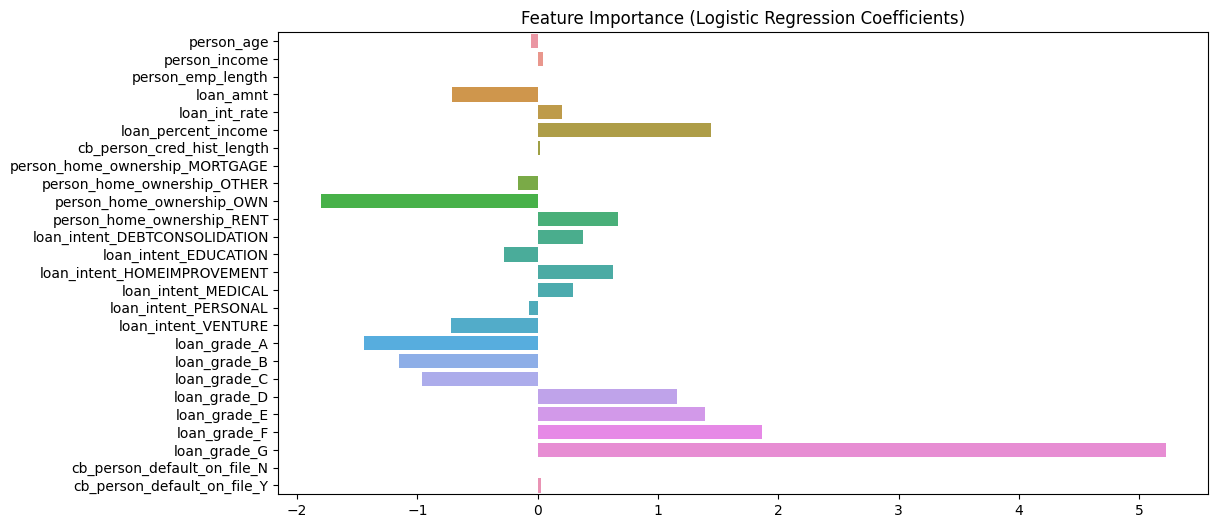

In [31]:
# Extract feature names from ColumnTransformer
num_features = num_cols
cat_features = grid_search.best_estimator_.named_steps['preprocessor']\
               .named_transformers_['cat'].named_steps['encoder']\
               .get_feature_names_out(cat_cols)
all_features = np.concatenate([num_features, cat_features])

# Plot coefficients for logistic regression
coefs = grid_search.best_estimator_.named_steps['classifier'].coef_[0]
plt.figure(figsize=(12, 6))
sns.barplot(x=coefs, y=all_features)
plt.title("Feature Importance (Logistic Regression Coefficients)")
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

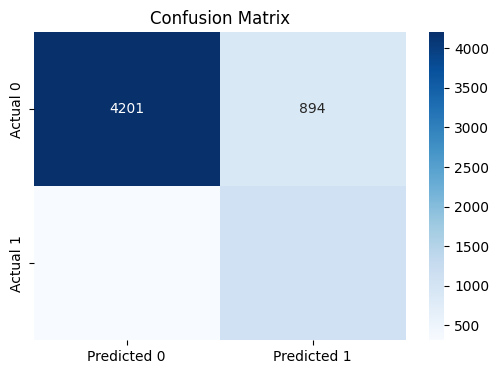

In [32]:
from sklearn.metrics import confusion_matrix

y_pred = grid_search.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title("Confusion Matrix")
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()